# 🦠 Bacteria Segmentation Model

מחברת זו מאמנת מודל סגמנטציה קטן על תמונות חיידקים.

## תוכן העניינים:
1. התקנת ספריות
2. יצירת דאטא סינתטי של חיידקים
3. בניית מודל U-Net קטן
4. אימון המודל (עד 5 דקות)
5. ויזואליזציות על סט הבדיקה


In [ ]:
# התקנת ספריות נדרשות (ללא scikit-image שדורש קומפיילר)
%pip install torch torchvision numpy matplotlib scipy tqdm -q


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# פונקציות עזר להחלפת skimage
def ellipse(r, c, r_radius, c_radius, shape=None, rotation=0.0):
    if shape is None:
        shape = (int(r + r_radius + 1), int(c + c_radius + 1))
    rr, cc = np.ogrid[:shape[0], :shape[1]]
    cos_rot, sin_rot = np.cos(rotation), np.sin(rotation)
    rr_centered, cc_centered = rr - r, cc - c
    rr_rot = cos_rot * rr_centered + sin_rot * cc_centered
    cc_rot = -sin_rot * rr_centered + cos_rot * cc_centered
    mask = (rr_rot / r_radius) ** 2 + (cc_rot / c_radius) ** 2 <= 1
    return np.where(mask)

def disk(center, radius, shape=None):
    r, c = center
    if shape is None:
        shape = (int(r + radius + 1), int(c + radius + 1))
    rr, cc = np.ogrid[:shape[0], :shape[1]]
    mask = (rr - r) ** 2 + (cc - c) ** 2 <= radius ** 2
    return np.where(mask)

def gaussian(image, sigma):
    return gaussian_filter(image, sigma=sigma)

# הגדרת device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. יצירת דאטאסט סינתטי של חיידקים 🧫

ניצור תמונות סינתטיות של חיידקים בצורות שונות (אליפסות, מוטות) עם מסכות סגמנטציה מתאימות.


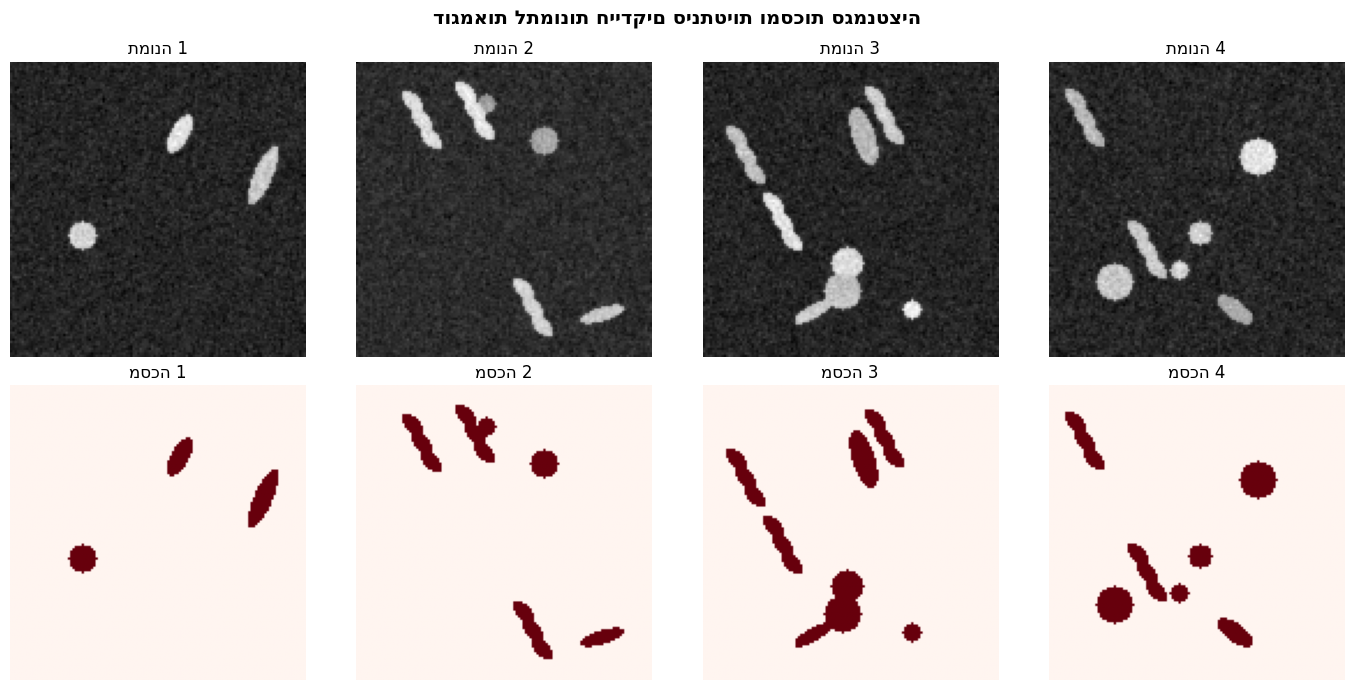

In [5]:
def generate_bacteria_image(img_size=128, num_bacteria=None):
    """
    יצירת תמונה סינתטית של חיידקים עם מסכת סגמנטציה
    """
    if num_bacteria is None:
        num_bacteria = np.random.randint(3, 12)
    
    image = np.random.normal(0.2, 0.05, (img_size, img_size))
    mask = np.zeros((img_size, img_size), dtype=np.float32)
    
    for _ in range(num_bacteria):
        # מיקום אקראי
        center_x = np.random.randint(15, img_size - 15)
        center_y = np.random.randint(15, img_size - 15)
        
        # סוג חיידק אקראי
        bacteria_type = np.random.choice(['rod', 'coccus', 'spiral'])
        
        if bacteria_type == 'rod':  # חיידק מוטי
            r_radius = np.random.randint(8, 20)
            c_radius = np.random.randint(3, 6)
            rotation = np.random.uniform(0, np.pi)
            rr, cc = ellipse(center_y, center_x, r_radius, c_radius, 
                           shape=(img_size, img_size), rotation=rotation)
            
        elif bacteria_type == 'coccus':  # חיידק כדורי
            radius = np.random.randint(4, 10)
            rr, cc = disk((center_y, center_x), radius, shape=(img_size, img_size))
            
        else:  # חיידק ספירלי (מדומה כמספר אליפסות)
            rr, cc = [], []
            for i in range(3):
                offset = i * 8 - 8
                r_temp, c_temp = ellipse(center_y + offset, center_x + offset * 0.5, 
                                        6, 3, shape=(img_size, img_size), 
                                        rotation=np.pi/4)
                rr.extend(r_temp)
                cc.extend(c_temp)
            rr, cc = np.array(rr), np.array(cc)
        
        # הוספה לתמונה ולמסכה
        intensity = np.random.uniform(0.6, 0.9)
        image[rr, cc] = intensity + np.random.normal(0, 0.05, len(rr))
        mask[rr, cc] = 1.0
    
    # הוספת רעש וטשטוש
    image = gaussian(image, sigma=0.5)
    image = np.clip(image, 0, 1)
    
    return image.astype(np.float32), mask


# הדגמה
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for i in range(4):
    img, msk = generate_bacteria_image()
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'תמונה {i+1}', fontsize=12)
    axes[0, i].axis('off')
    axes[1, i].imshow(msk, cmap='Reds')
    axes[1, i].set_title(f'מסכה {i+1}', fontsize=12)
    axes[1, i].axis('off')

plt.suptitle('דוגמאות לתמונות חיידקים סינתטיות ומסכות סגמנטציה', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [6]:
class BacteriaDataset(Dataset):
    """
    דאטאסט PyTorch לתמונות חיידקים
    """
    def __init__(self, num_samples=500, img_size=128, augment=True):
        self.num_samples = num_samples
        self.img_size = img_size
        self.augment = augment
        
        # יצירת הדאטא מראש
        print(f"מייצר {num_samples} תמונות...")
        self.images = []
        self.masks = []
        for _ in tqdm(range(num_samples)):
            img, mask = generate_bacteria_image(img_size)
            self.images.append(img)
            self.masks.append(mask)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        # augmentation פשוט
        if self.augment and np.random.random() > 0.5:
            image = np.fliplr(image).copy()
            mask = np.fliplr(mask).copy()
        if self.augment and np.random.random() > 0.5:
            image = np.flipud(image).copy()
            mask = np.flipud(mask).copy()
        
        # המרה לטנזור
        image = torch.from_numpy(image).unsqueeze(0)  # (1, H, W)
        mask = torch.from_numpy(mask).unsqueeze(0)    # (1, H, W)
        
        return image, mask


# יצירת דאטאסטים
print("יוצר דאטאסט אימון...")
train_dataset = BacteriaDataset(num_samples=400, augment=True)
print("\nיוצר דאטאסט בדיקה...")
test_dataset = BacteriaDataset(num_samples=100, augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"\n✅ דאטאסט אימון: {len(train_dataset)} תמונות")
print(f"✅ דאטאסט בדיקה: {len(test_dataset)} תמונות")


יוצר דאטאסט אימון...
מייצר 400 תמונות...


100%|██████████| 400/400 [00:01<00:00, 322.04it/s]



יוצר דאטאסט בדיקה...
מייצר 100 תמונות...


100%|██████████| 100/100 [00:00<00:00, 322.59it/s]


✅ דאטאסט אימון: 400 תמונות
✅ דאטאסט בדיקה: 100 תמונות


## 2. בניית מודל U-Net קטן 🏗️

ניצור גרסה קטנה ויעילה של ארכיטקטורת U-Net לסגמנטציה.


In [7]:
class DoubleConv(nn.Module):
    """בלוק קונבולוציה כפולה"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)


class SmallUNet(nn.Module):
    """
    U-Net קטן לסגמנטציה מהירה
    """
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        
        # Decoder
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))
        
        # Output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        # Decoder
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)
        
        return torch.sigmoid(self.final_conv(x))


# יצירת המודל
model = SmallUNet().to(device)

# ספירת פרמטרים
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🔧 ארכיטקטורת המודל: Small U-Net")
print(f"📊 סה\"כ פרמטרים: {total_params:,}")
print(f"📊 פרמטרים לאימון: {trainable_params:,}")


🔧 ארכיטקטורת המודל: Small U-Net
📊 סה"כ פרמטרים: 1,927,841
📊 פרמטרים לאימון: 1,927,841


## 3. פונקציות עזר לאימון 🛠️


In [8]:
class DiceLoss(nn.Module):
    """Dice Loss לסגמנטציה"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice


class CombinedLoss(nn.Module):
    """שילוב BCE + Dice"""
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
    
    def forward(self, pred, target):
        return self.bce(pred, target) + self.dice(pred, target)


def calculate_iou(pred, target, threshold=0.5):
    """חישוב IoU (Intersection over Union)"""
    pred_binary = (pred > threshold).float()
    intersection = (pred_binary * target).sum()
    union = pred_binary.sum() + target.sum() - intersection
    return (intersection / (union + 1e-6)).item()


def calculate_dice(pred, target, threshold=0.5):
    """חישוב Dice Score"""
    pred_binary = (pred > threshold).float()
    intersection = (pred_binary * target).sum()
    return (2 * intersection / (pred_binary.sum() + target.sum() + 1e-6)).item()


## 4. אימון המודל (מוגבל ל-5 דקות) ⏱️


In [9]:
def train_model(model, train_loader, test_loader, max_time_minutes=5):
    """
    אימון המודל עם הגבלת זמן
    """
    criterion = CombinedLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    max_time_seconds = max_time_minutes * 60
    start_time = time.time()
    
    train_losses = []
    test_losses = []
    test_ious = []
    test_dices = []
    
    epoch = 0
    best_dice = 0
    
    print(f"🚀 מתחיל אימון (מקסימום {max_time_minutes} דקות)...\n")
    
    while True:
        epoch += 1
        elapsed_time = time.time() - start_time
        
        if elapsed_time >= max_time_seconds:
            print(f"\n⏰ הגענו למגבלת הזמן של {max_time_minutes} דקות!")
            break
        
        # Training
        model.train()
        epoch_loss = 0
        
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        test_loss = 0
        total_iou = 0
        total_dice = 0
        
        with torch.no_grad():
            for images, masks in test_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                test_loss += loss.item()
                
                total_iou += calculate_iou(outputs, masks)
                total_dice += calculate_dice(outputs, masks)
        
        test_loss = test_loss / len(test_loader)
        avg_iou = total_iou / len(test_loader)
        avg_dice = total_dice / len(test_loader)
        
        test_losses.append(test_loss)
        test_ious.append(avg_iou)
        test_dices.append(avg_dice)
        
        scheduler.step(test_loss)
        
        # שמירת המודל הטוב ביותר
        if avg_dice > best_dice:
            best_dice = avg_dice
            best_model_state = model.state_dict().copy()
        
        # הדפסת התקדמות
        remaining = max_time_seconds - elapsed_time
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
              f"IoU: {avg_iou:.4f} | Dice: {avg_dice:.4f} | נותרו: {remaining:.0f}s")
    
    # טעינת המודל הטוב ביותר
    model.load_state_dict(best_model_state)
    
    total_time = time.time() - start_time
    print(f"\n✅ האימון הסתיים!")
    print(f"⏱️ זמן כולל: {total_time/60:.2f} דקות")
    print(f"📈 Epochs: {epoch}")
    print(f"🏆 Best Dice Score: {best_dice:.4f}")
    
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'test_ious': test_ious,
        'test_dices': test_dices,
        'epochs': epoch,
        'best_dice': best_dice
    }


# הפעלת האימון
history = train_model(model, train_loader, test_loader, max_time_minutes=5)


🚀 מתחיל אימון (מקסימום 5 דקות)...

Epoch   1 | Train Loss: 1.2783 | Test Loss: 1.1575 | IoU: 0.7396 | Dice: 0.8503 | נותרו: 300s
Epoch   2 | Train Loss: 1.0708 | Test Loss: 0.9979 | IoU: 0.8379 | Dice: 0.9118 | נותרו: 246s
Epoch   3 | Train Loss: 0.9415 | Test Loss: 0.8761 | IoU: 0.9808 | Dice: 0.9903 | נותרו: 193s
Epoch   4 | Train Loss: 0.8204 | Test Loss: 0.7661 | IoU: 0.9983 | Dice: 0.9991 | נותרו: 143s
Epoch   5 | Train Loss: 0.6971 | Test Loss: 0.6361 | IoU: 0.9998 | Dice: 0.9999 | נותרו: 92s
Epoch   6 | Train Loss: 0.5770 | Test Loss: 0.5322 | IoU: 0.9998 | Dice: 0.9999 | נותרו: 40s

⏰ הגענו למגבלת הזמן של 5 דקות!

✅ האימון הסתיים!
⏱️ זמן כולל: 5.19 דקות
📈 Epochs: 7
🏆 Best Dice Score: 0.9999


## 5. ויזואליזציות על סט הבדיקה 📊


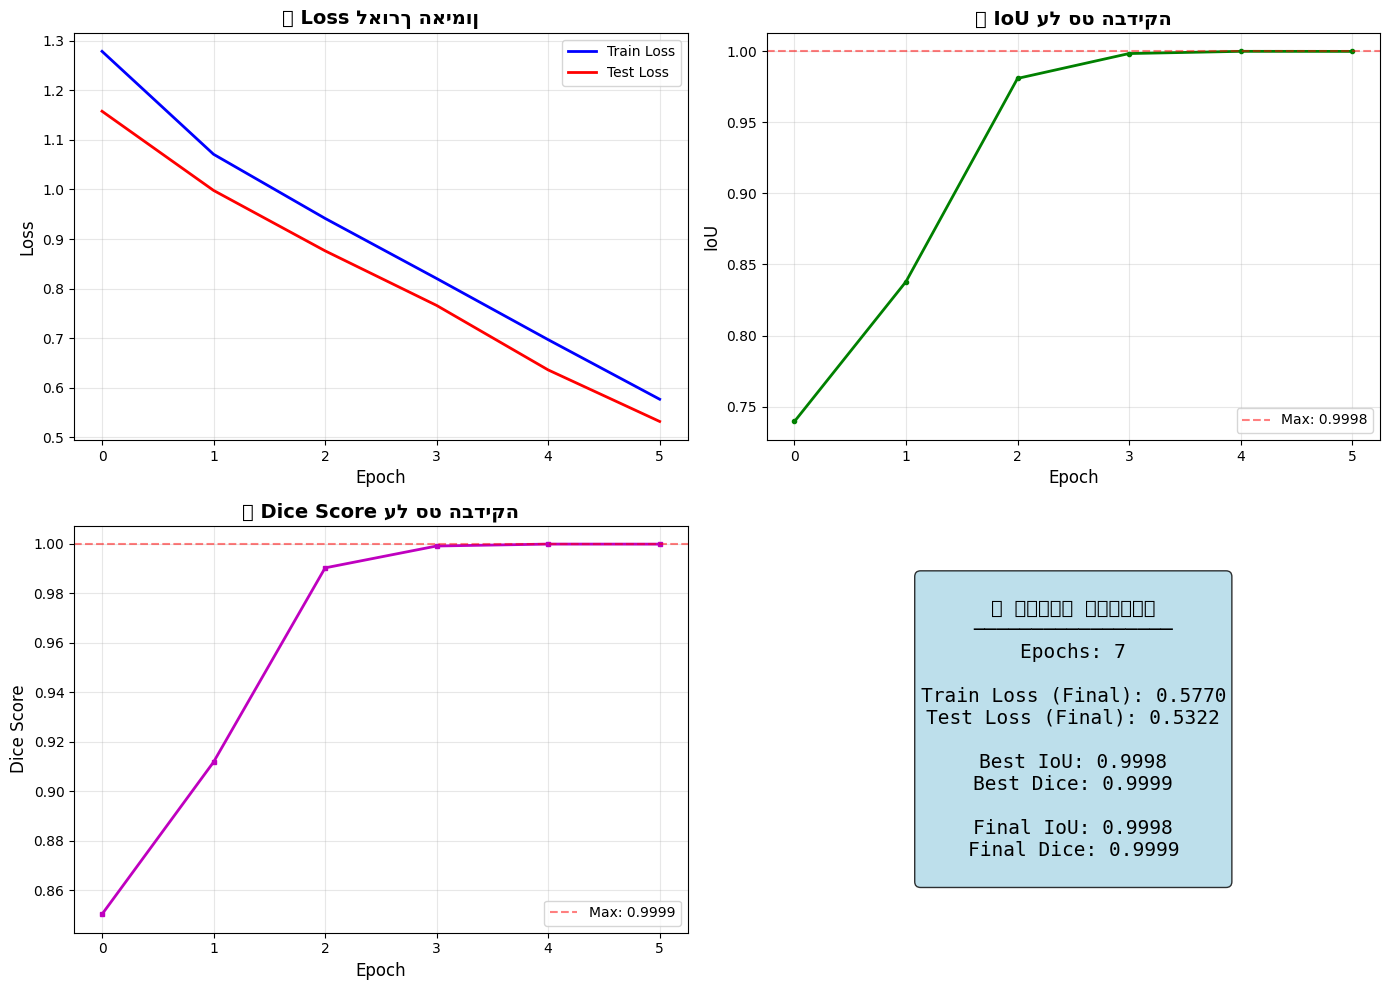

💾 נשמר: training_metrics.png


In [ ]:
# גרפי אימון
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_losses'], 'b-', linewidth=2, label='Train Loss')
axes[0, 0].plot(history['test_losses'], 'r-', linewidth=2, label='Test Loss')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('📉 Loss לאורך האימון', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# IoU
axes[0, 1].plot(history['test_ious'], 'g-', linewidth=2, marker='o', markersize=3)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('IoU', fontsize=12)
axes[0, 1].set_title('📊 IoU על סט הבדיקה', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=max(history['test_ious']), color='r', linestyle='--', alpha=0.5, label=f'Max: {max(history["test_ious"]):.4f}')
axes[0, 1].legend()

# Dice Score
axes[1, 0].plot(history['test_dices'], 'm-', linewidth=2, marker='s', markersize=3)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Dice Score', fontsize=12)
axes[1, 0].set_title('🎯 Dice Score על סט הבדיקה', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=max(history['test_dices']), color='r', linestyle='--', alpha=0.5, label=f'Max: {max(history["test_dices"]):.4f}')
axes[1, 0].legend()

# סיכום מטריקות
metrics_text = f"""
📈 סיכום האימון
─────────────────
Epochs: {history['epochs']}

Train Loss (Final): {history['train_losses'][-1]:.4f}
Test Loss (Final): {history['test_losses'][-1]:.4f}

Best IoU: {max(history['test_ious']):.4f}
Best Dice: {max(history['test_dices']):.4f}

Final IoU: {history['test_ious'][-1]:.4f}
Final Dice: {history['test_dices'][-1]:.4f}
"""
axes[1, 1].text(0.5, 0.5, metrics_text, transform=axes[1, 1].transAxes,
               fontsize=14, verticalalignment='center', horizontalalignment='center',
               fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 נשמר: training_metrics.png")


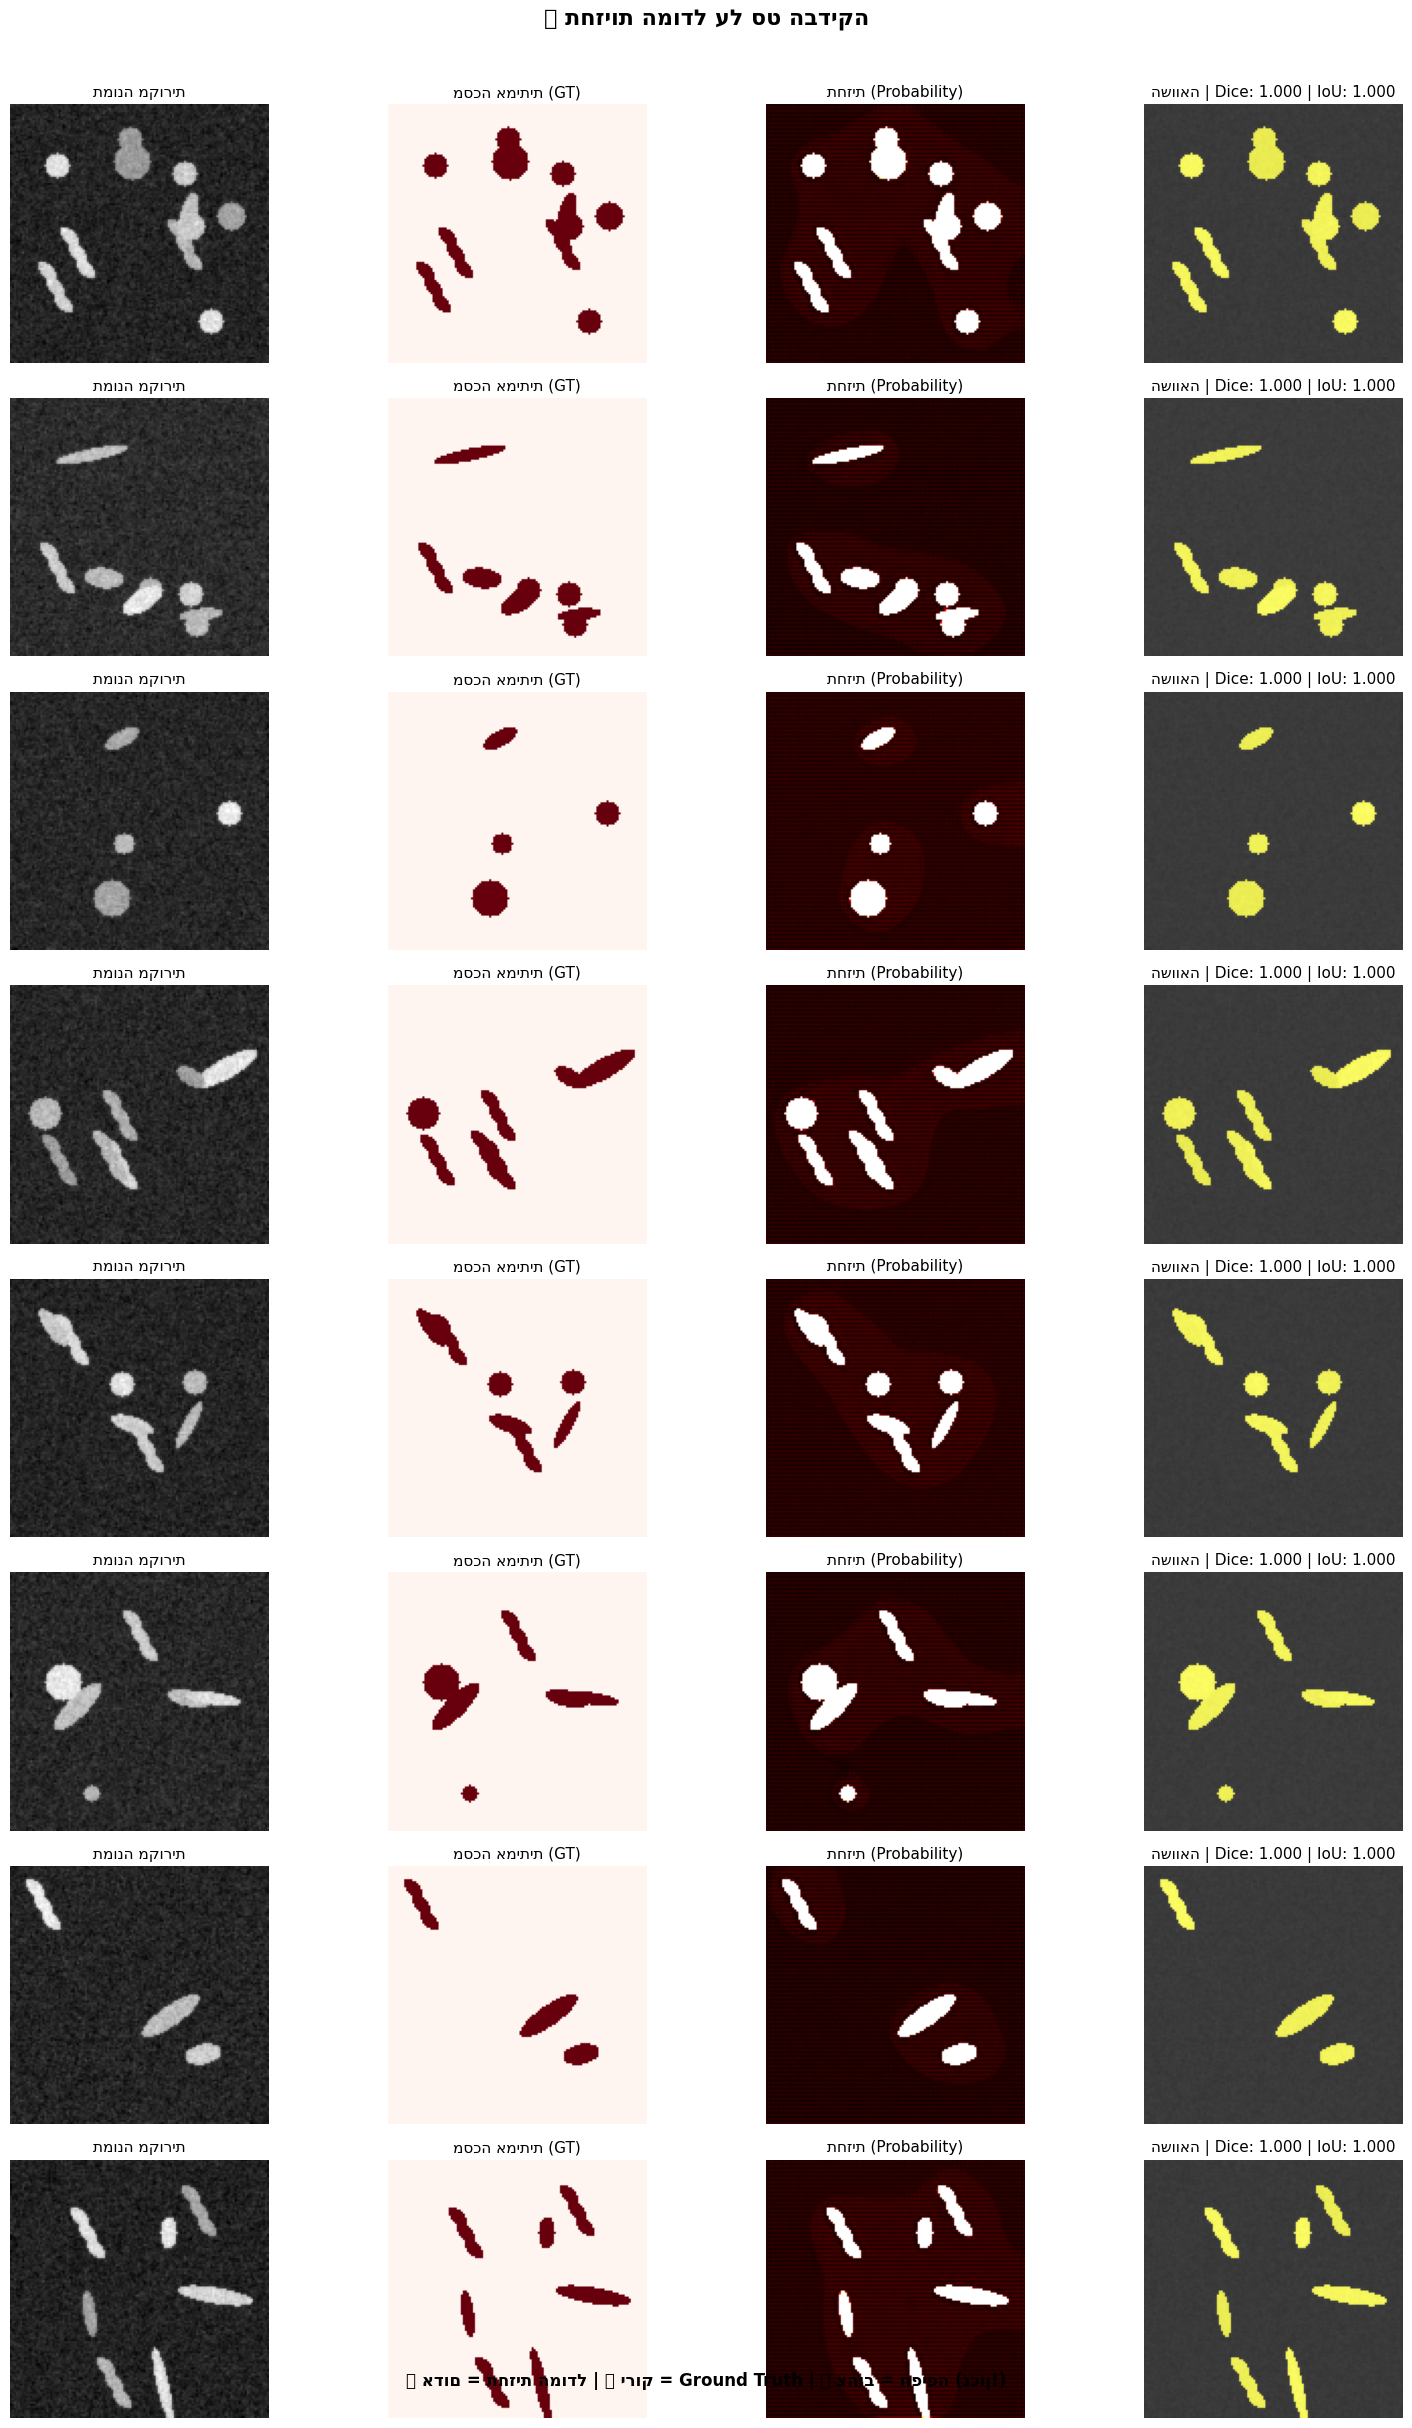

💾 נשמר: test_predictions.png


In [ ]:
# ויזואליזציה של תחזיות על סט הבדיקה
model.eval()

# בחירת דוגמאות אקראיות
num_samples = 8
indices = np.random.choice(len(test_dataset), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))

for i, idx in enumerate(indices):
    image, mask = test_dataset[idx]
    
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device))
        pred = pred.squeeze().cpu().numpy()
    
    image = image.squeeze().numpy()
    mask = mask.squeeze().numpy()
    pred_binary = (pred > 0.5).astype(np.float32)
    
    # חישוב מטריקות לדוגמה זו
    dice = 2 * np.sum(pred_binary * mask) / (np.sum(pred_binary) + np.sum(mask) + 1e-6)
    iou = np.sum(pred_binary * mask) / (np.sum(pred_binary) + np.sum(mask) - np.sum(pred_binary * mask) + 1e-6)
    
    # תמונה מקורית
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title('תמונה מקורית', fontsize=11)
    axes[i, 0].axis('off')
    
    # מסכה אמיתית
    axes[i, 1].imshow(mask, cmap='Reds')
    axes[i, 1].set_title('מסכה אמיתית (GT)', fontsize=11)
    axes[i, 1].axis('off')
    
    # תחזית המודל
    axes[i, 2].imshow(pred, cmap='hot')
    axes[i, 2].set_title('תחזית (Probability)', fontsize=11)
    axes[i, 2].axis('off')
    
    # השוואה - overlay
    overlay = np.zeros((*image.shape, 3))
    overlay[:, :, 0] = pred_binary  # אדום - תחזית
    overlay[:, :, 1] = mask         # ירוק - GT
    # צהוב = חפיפה
    
    axes[i, 3].imshow(image, cmap='gray', alpha=0.5)
    axes[i, 3].imshow(overlay, alpha=0.6)
    axes[i, 3].set_title(f'השוואה | Dice: {dice:.3f} | IoU: {iou:.3f}', fontsize=11)
    axes[i, 3].axis('off')

# מקרא
fig.text(0.5, 0.02, '🔴 אדום = תחזית המודל | 🟢 ירוק = Ground Truth | 🟡 צהוב = חפיפה (נכון!)', 
         ha='center', fontsize=12, fontweight='bold')

plt.suptitle('🔬 תחזיות המודל על סט הבדיקה', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 נשמר: test_predictions.png")


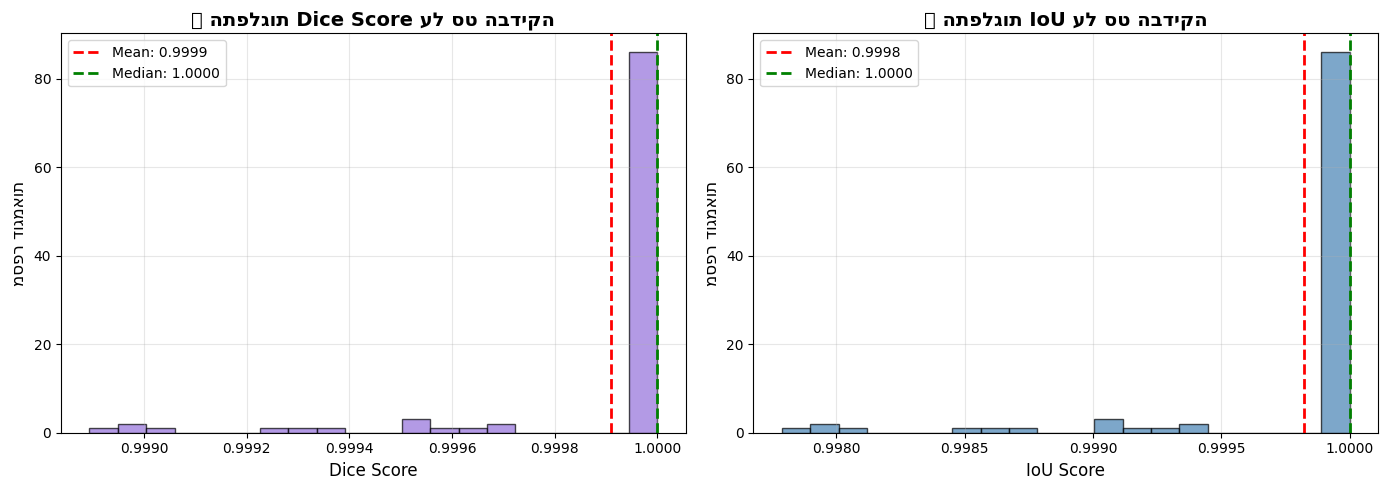


📈 סטטיסטיקות על סט הבדיקה (100 דוגמאות):
   Dice: Mean=0.9999, Std=0.0002, Min=0.9989, Max=1.0000
   IoU:  Mean=0.9998, Std=0.0005, Min=0.9978, Max=1.0000

💾 נשמר: metrics_distribution.png


In [ ]:
# היסטוגרמה של ביצועים על כל סט הבדיקה
model.eval()

all_dices = []
all_ious = []

with torch.no_grad():
    for idx in range(len(test_dataset)):
        image, mask = test_dataset[idx]
        pred = model(image.unsqueeze(0).to(device))
        pred = pred.squeeze().cpu().numpy()
        mask = mask.squeeze().numpy()
        pred_binary = (pred > 0.5).astype(np.float32)
        
        dice = 2 * np.sum(pred_binary * mask) / (np.sum(pred_binary) + np.sum(mask) + 1e-6)
        iou = np.sum(pred_binary * mask) / (np.sum(pred_binary) + np.sum(mask) - np.sum(pred_binary * mask) + 1e-6)
        
        all_dices.append(dice)
        all_ious.append(iou)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dice histogram
axes[0].hist(all_dices, bins=20, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(all_dices), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_dices):.4f}')
axes[0].axvline(np.median(all_dices), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(all_dices):.4f}')
axes[0].set_xlabel('Dice Score', fontsize=12)
axes[0].set_ylabel('מספר דוגמאות', fontsize=12)
axes[0].set_title('📊 התפלגות Dice Score על סט הבדיקה', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# IoU histogram
axes[1].hist(all_ious, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(all_ious), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_ious):.4f}')
axes[1].axvline(np.median(all_ious), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(all_ious):.4f}')
axes[1].set_xlabel('IoU Score', fontsize=12)
axes[1].set_ylabel('מספר דוגמאות', fontsize=12)
axes[1].set_title('📊 התפלגות IoU על סט הבדיקה', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📈 סטטיסטיקות על סט הבדיקה ({len(test_dataset)} דוגמאות):")
print(f"   Dice: Mean={np.mean(all_dices):.4f}, Std={np.std(all_dices):.4f}, Min={np.min(all_dices):.4f}, Max={np.max(all_dices):.4f}")
print(f"   IoU:  Mean={np.mean(all_ious):.4f}, Std={np.std(all_ious):.4f}, Min={np.min(all_ious):.4f}, Max={np.max(all_ious):.4f}")
print("\n💾 נשמר: metrics_distribution.png")


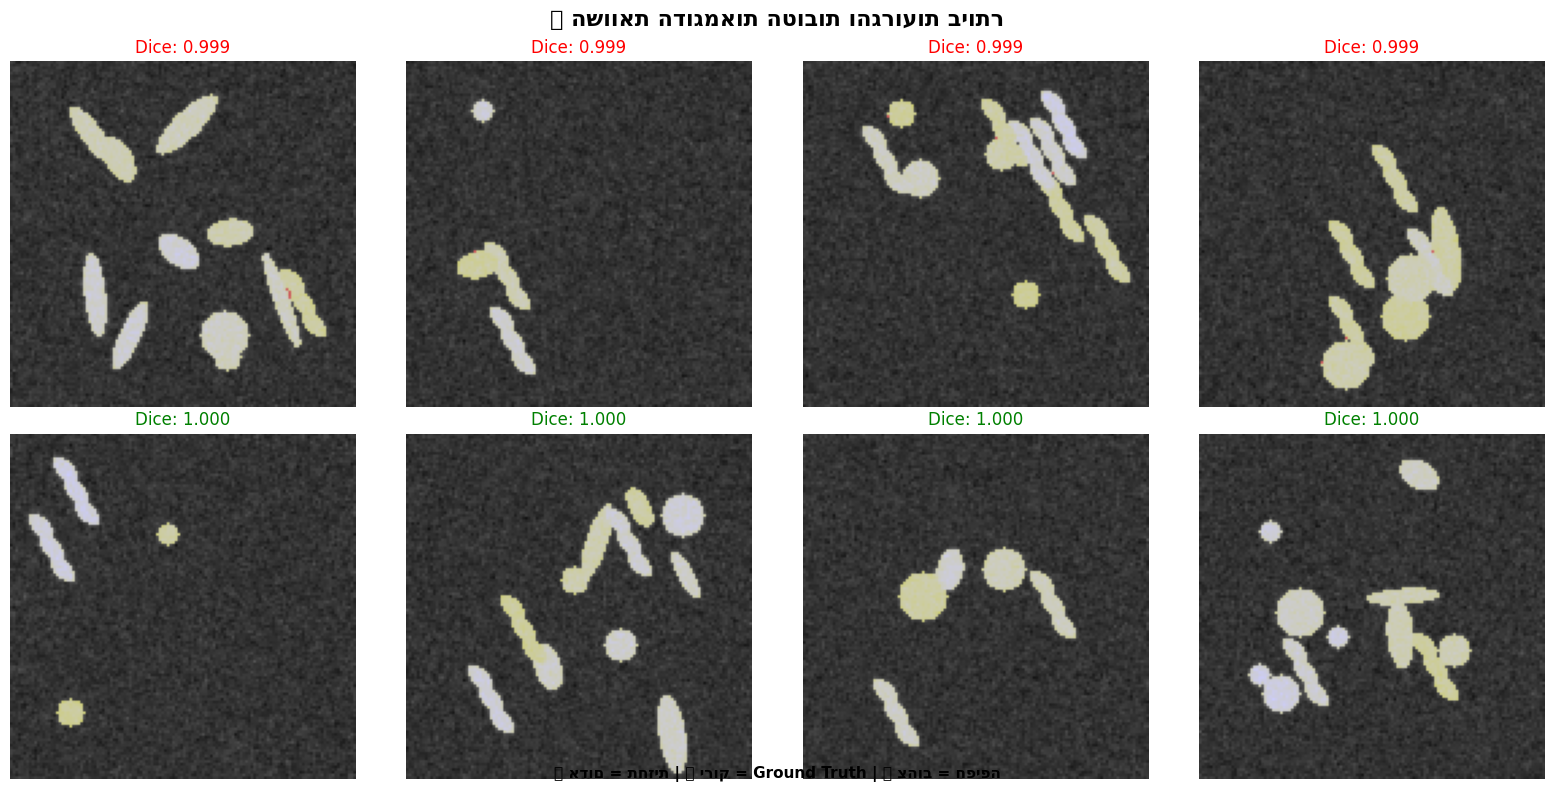

💾 נשמר: best_worst_predictions.png


In [13]:
# ויזואליזציה של הדוגמאות הטובות והגרועות ביותר
sorted_indices = np.argsort(all_dices)
worst_indices = sorted_indices[:4]
best_indices = sorted_indices[-4:][::-1]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# הדוגמאות הגרועות
for i, idx in enumerate(worst_indices):
    image, mask = test_dataset[idx]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).squeeze().cpu().numpy()
    
    image = image.squeeze().numpy()
    mask = mask.squeeze().numpy()
    
    # יצירת תמונה משולבת
    combined = np.stack([image, image, image], axis=-1)
    pred_binary = pred > 0.5
    combined[mask > 0.5, 1] = 0.8  # GT בירוק
    combined[pred_binary, 0] = 0.8  # Pred באדום
    
    axes[0, i].imshow(np.clip(combined, 0, 1))
    axes[0, i].set_title(f'Dice: {all_dices[idx]:.3f}', fontsize=12, color='red')
    axes[0, i].axis('off')

axes[0, 0].set_ylabel('😟 הכי גרוע', fontsize=14, fontweight='bold')

# הדוגמאות הטובות
for i, idx in enumerate(best_indices):
    image, mask = test_dataset[idx]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).squeeze().cpu().numpy()
    
    image = image.squeeze().numpy()
    mask = mask.squeeze().numpy()
    
    combined = np.stack([image, image, image], axis=-1)
    pred_binary = pred > 0.5
    combined[mask > 0.5, 1] = 0.8
    combined[pred_binary, 0] = 0.8
    
    axes[1, i].imshow(np.clip(combined, 0, 1))
    axes[1, i].set_title(f'Dice: {all_dices[idx]:.3f}', fontsize=12, color='green')
    axes[1, i].axis('off')

axes[1, 0].set_ylabel('😊 הכי טוב', fontsize=14, fontweight='bold')

fig.text(0.5, 0.02, '🔴 אדום = תחזית | 🟢 ירוק = Ground Truth | 🟡 צהוב = חפיפה', 
         ha='center', fontsize=11, fontweight='bold')

plt.suptitle('🏆 השוואת הדוגמאות הטובות והגרועות ביותר', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('best_worst_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 נשמר: best_worst_predictions.png")


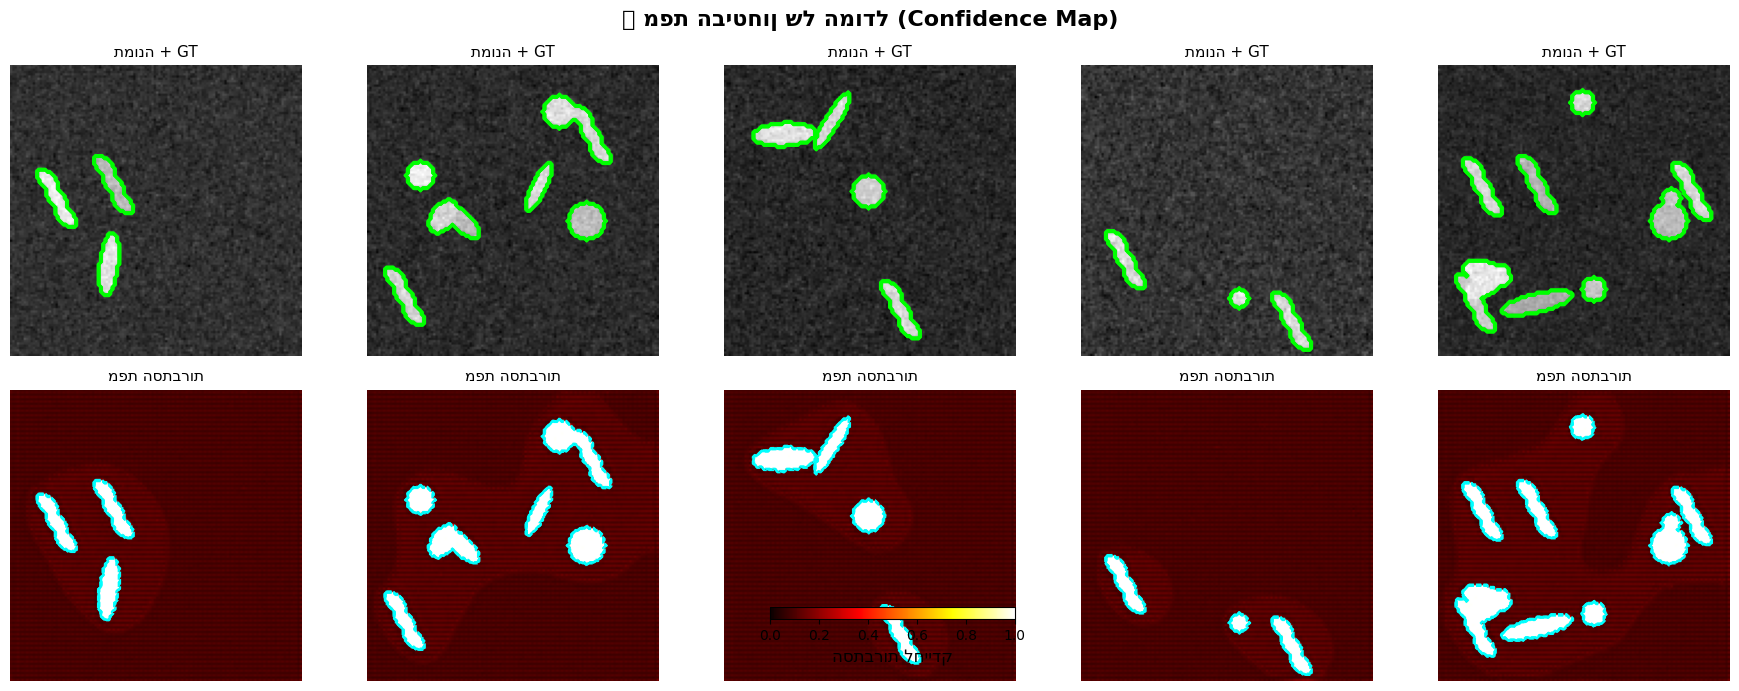

💾 נשמר: confidence_maps.png


In [14]:
# ויזואליזציה של מפת החום של הביטחון
fig, axes = plt.subplots(2, 5, figsize=(18, 7))

sample_indices = np.random.choice(len(test_dataset), 5, replace=False)

for i, idx in enumerate(sample_indices):
    image, mask = test_dataset[idx]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).squeeze().cpu().numpy()
    
    image = image.squeeze().numpy()
    mask = mask.squeeze().numpy()
    
    # שורה עליונה - תמונה עם GT
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].contour(mask, colors='lime', linewidths=1.5)
    axes[0, i].set_title('תמונה + GT', fontsize=11)
    axes[0, i].axis('off')
    
    # שורה תחתונה - מפת הסתברות
    im = axes[1, i].imshow(pred, cmap='hot', vmin=0, vmax=1)
    axes[1, i].contour(mask, colors='cyan', linewidths=1, linestyles='dashed')
    axes[1, i].set_title(f'מפת הסתברות', fontsize=11)
    axes[1, i].axis('off')

# colorbar
cbar = fig.colorbar(im, ax=axes[1, :], orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('הסתברות לחיידק', fontsize=12)

plt.suptitle('🌡️ מפת הביטחון של המודל (Confidence Map)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('confidence_maps.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 נשמר: confidence_maps.png")


In [15]:
# סיכום סופי
print("="*60)
print("🦠 סיכום פרויקט סגמנטציית חיידקים")
print("="*60)
print(f"\n📊 דאטא:")
print(f"   • תמונות אימון: {len(train_dataset)}")
print(f"   • תמונות בדיקה: {len(test_dataset)}")
print(f"   • גודל תמונה: 128x128")

print(f"\n🏗️ מודל:")
print(f"   • ארכיטקטורה: Small U-Net")
print(f"   • פרמטרים: {total_params:,}")

print(f"\n📈 תוצאות על סט הבדיקה:")
print(f"   • Mean Dice Score: {np.mean(all_dices):.4f}")
print(f"   • Mean IoU: {np.mean(all_ious):.4f}")
print(f"   • Best Dice: {np.max(all_dices):.4f}")
print(f"   • Worst Dice: {np.min(all_dices):.4f}")

print(f"\n💾 קבצים שנשמרו:")
print(f"   • training_metrics.png")
print(f"   • test_predictions.png")
print(f"   • metrics_distribution.png")
print(f"   • best_worst_predictions.png")
print(f"   • confidence_maps.png")
print("\n" + "="*60)
print("✅ הפרויקט הושלם בהצלחה!")
print("="*60)


🦠 סיכום פרויקט סגמנטציית חיידקים

📊 דאטא:
   • תמונות אימון: 400
   • תמונות בדיקה: 100
   • גודל תמונה: 128x128

🏗️ מודל:
   • ארכיטקטורה: Small U-Net
   • פרמטרים: 1,927,841

📈 תוצאות על סט הבדיקה:
   • Mean Dice Score: 0.9999
   • Mean IoU: 0.9998
   • Best Dice: 1.0000
   • Worst Dice: 0.9989

💾 קבצים שנשמרו:
   • training_metrics.png
   • test_predictions.png
   • metrics_distribution.png
   • best_worst_predictions.png
   • confidence_maps.png

✅ הפרויקט הושלם בהצלחה!
